# File and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


filepath=r'data/df_merch_5_scaler_input.csv'


file_tag = "df_merch_balancing_input"

# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:
test_data=True
# test_data=False

if test_data==True:

    data=pd.read_csv(filepath)

    # smaller sample to test
    data=data.sample(frac=0.05, replace=False)
    

else:
    data=pd.read_csv(filepath)
    # 50% sample
    # data=data.sample(frac=0.5, replace=False)

 
target='returning_user'
vars: list[str] = data.columns.to_list()


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37168 entries, 736 to 742880
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   event_name                       37168 non-null  float64
 1   device_category                  37168 non-null  float64
 2   device_mobile_brand_name         37168 non-null  float64
 3   device_mobile_model_name         37168 non-null  float64
 4   device_operating_system          37168 non-null  float64
 5   device_operating_system_version  37168 non-null  float64
 6   device_language                  37168 non-null  float64
 7   device_web_info_browser          37168 non-null  float64
 8   device_web_info_browser_version  37168 non-null  float64
 9   geo_region                       37168 non-null  float64
 10  geo_city                         37168 non-null  float64
 11  traffic_source_medium            37168 non-null  float64
 12  traffic_source_sourc

# Balancing Analysis

Minority class= 1.0 : 9556
Majority class= 0.0 : 27612
Proportion: 0.35 : 1


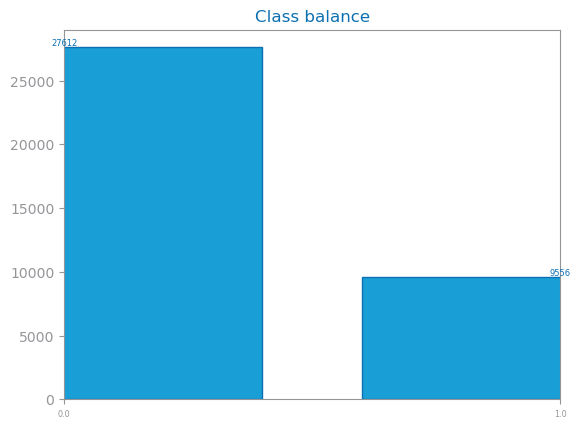

In [5]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart


target_count: Series = data[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

# Balance 1 - Undersampling

## Bal 1 strategy Application

In [6]:
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler



def apply_strategy_1(df: DataFrame) -> DataFrame:

    df_copy=df.copy()

    # this script is available in data_functions originally from DSLabs site in Outlier chapter

    # Ensure positive_class and negative_class are defined and match the target values
    positive_class = 1  # Or whatever your positive class value is
    negative_class = 0  # Or whatever your negative class value is

    # Separate the majority and minority classes
    df_majority = df_copy[df_copy[target] == negative_class]
    df_minority = df_copy[df_copy[target] == positive_class]

    # Check the class distribution
    print(f"Original class distribution:\n{df_copy[target].value_counts(normalize=True) * 100}\n")

    # Downsample the majority class to match the size of the minority class
    df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

    # Combine the downsampled majority class with the minority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Shuffle the combined dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    df_balanced.sort_values(by='day_of_year', inplace=True)
    

    # Check the new class distribution to verify the balance
    print(f"Balanced class distribution:\n{df_balanced[target].value_counts(normalize=True) * 100}\n")


    # Check class distribution
    values = df_balanced[target].value_counts(normalize=True) 
    print(values)

    
    return df_balanced


data_1=apply_strategy_1(data)





Original class distribution:
returning_user
0.0    74.289712
1.0    25.710288
Name: proportion, dtype: float64

Balanced class distribution:
returning_user
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64

returning_user
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [7]:
print(data_1[target].unique())


[0. 1.]


## Bal 1 Target Prep

In [8]:
from numpy import array, ndarray


y_1, X_1, labels, values = define_target_and_prepare_data(data_1, target)


Labels=[0.0, 1.0]


## Bal 1 train/test split 

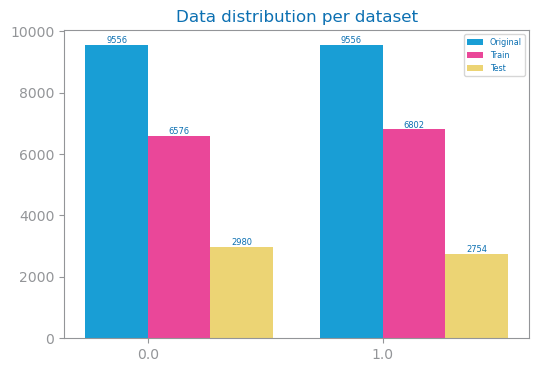

In [9]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart


# Call the function to split the data
train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=data_1.columns), y_1, data_columns=data_1.columns, target_column=target)

# Distribution check
values["Train"] = [
    len(train_1[train_1[target] == 0]),
    len(train_1[train_1[target] == 1]),
]
values["Test"] = [
    len(test_1[test_1[target] == 0]),
    len(test_1[test_1[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Bal 1 evaluate

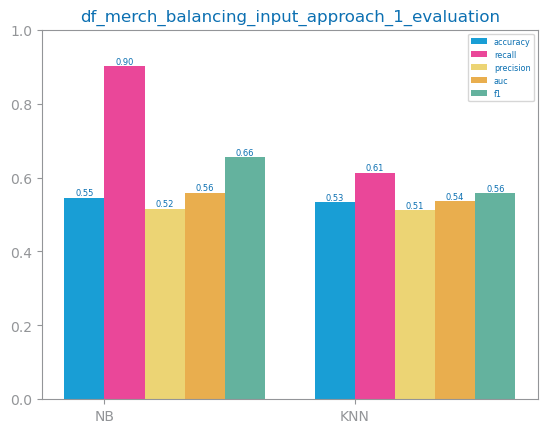

In [10]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

figure()
eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='returning_user', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_1_evaluation", percentage=True
)
savefig(f"images/{file_tag}_approach_1_evaluation.png")
show()

# Bal 2 - SMOTE


## Bal 2 strategy aplication

In [18]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

def apply_strategy_2(df):

   # Copy the DataFrame
    original = df.copy()

    # Define random state for reproducibility
    RANDOM_STATE = 42

    # Separate the features (X) and target (y)
    y = original.pop(target).values
    X: ndarray = original.values

    # Initialize SMOTE
    smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)

    # Fit and resample
    smote_X, smote_y = smote.fit_resample(X, y)

    # Reconstruct the DataFrame from the SMOTE output
    df_smote = concat([DataFrame(smote_X, columns=original.columns), DataFrame(smote_y, columns=[target])], axis=1)


    # Print class distribution and shape
    smote_target_count: Series = Series(smote_y).value_counts()
    print("Minority class=", smote_target_count.index[1], ":", smote_target_count[1])
    print("Majority class=", smote_target_count.index[0], ":", smote_target_count[0])
    print(
        "Proportion:",
        round(smote_target_count[1] / smote_target_count[0], 2),
        ": 1",
    )
    print("Shape of the new DataFrame:", df_smote.shape)

    print("Class counts after SMOTE:")
    print(df_smote[target].value_counts())

    return df_smote

data_2=apply_strategy_2(data)


Minority class= 1.0 : 27612
Majority class= 0.0 : 27612
Proportion: 1.0 : 1
Shape of the new DataFrame: (55224, 42)
Class counts after SMOTE:
returning_user
0.0    27612
1.0    27612
Name: count, dtype: int64


## Bal 2 target prep

In [19]:
y_2, X_2, labels, class_counts = define_target_and_prepare_data(data_2, target=target)


Labels=[0.0, 1.0]


## Bal 2 train/test split 

<Axes: title={'center': 'Data distribution per dataset'}>

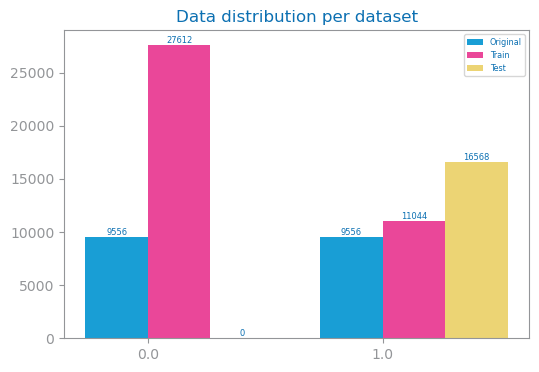

In [20]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart

# train/test split from DSLABS Classification/Evaluation Chapter
# created split_data_save_csv on data_functions

# Call the function to split the data
train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=data_2.columns), y_2, data_columns=data_2.columns, target_column=target)


values["Train"] = [
    len(train_2[train_2[target] == 0]),
    len(train_2[train_2[target] == 1]),
]
values["Test"] = [
    len(test_2[test_2[target] == 0]),
    len(test_2[test_2[target] == 1]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")

## Bal 2 evaluate

In [21]:

figure()
eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='returning_user', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_2, title=f"{file_tag}_approach_2_evaluation", percentage=True
)
savefig(f"images/{file_tag}_approach_2_evaluation.png")
show()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

<Figure size 640x480 with 0 Axes>

# Approach uplift comparison

## uplift df

In [ ]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

# Calculate uplift
df_uplift = df_eval_2 - df_eval_1



# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



# Display the DataFrame
comparison_df

# Analysis

- Uplift between outlier input approaches is specially significant when it comes to recall (55.7%  out1 to 37% out2). 
- Accuracy however is lower on out1 vs out2 treatment strategies
- data processing time is almost equal
- Considering out1 is the best between both strategies, if we compare between previous dataset and outlier treatment, we have
    - an improvement in NB recall (0.35 to 0.55!)
    - slight loss in NB accuracy: 0.63 to 0.59 
    - slight improvement in NB's auc and f1 
    - no significant improvements in KNN

- Considering we seriously want to improve recall, then we will move forward with strategy outlier 1 (thresholding outliers)

## AI insight on recall

Why Recall Matters in Predicting Returning Users:

1. Maximizing Engagement Opportunities:

    - Predicting returning users correctly allows for personalized marketing, tailored content, and targeted offers. If the system misses a returning user (false negative), it’s a missed opportunity to engage with a user who could otherwise benefit from personalized strategies.
    - Having a higher recall ensures that you’re capturing the maximum number of actual returning users, even if some non-returning users are mistakenly classified as returning (false positives).

2. False Positives Aren’t as Costly:
    - In this case, a false positive means treating a new user as a returning user. While this might slightly reduce the accuracy of personalization, the cost of this mistake is generally low (e.g., showing personalized recommendations to a non-returning user).
    - False negatives (missing true returning users), on the other hand, mean lost opportunities for accurate personalization and retention efforts, which could directly affect engagement and conversion.

3. Personalization Strategies and Marketing Tactics:
    - Since personalization and remarketing strategies often rely on recognizing returning users, prioritizing recall ensures that your campaigns are more inclusive, targeting as many actual returning users as possible.
    - Even if your system misclassifies some users, the effect on user experience is minor compared to the benefit of catching more real returning users and improving their experience.

4. Conclusion:
    - Given that false positives are not very costly in your scenario and maximizing engagement with true returning users is key, focusing on better recall makes sense. The out1 strategy, which provides a significant recall improvement, would likely be more effective in helping your system predict returning users more accurately and improving marketing efforts.

# save to csv

In [39]:
if test_data==False:
    
    # 
    # data=apply_strategy_1(data)
    
    data.to_csv(f"data/df_merch_5_scaler_input.csv", index=False)
    